### TransformerArchitecturesInFPGAs_Stage4_Task1

In [1]:
# ##############################################################################
# Section 1: Environment Setup and Library Imports
# This section sets the Keras backend to JAX for optimal performance and imports all
# necessary libraries, including keras, numpy, matplotlib, and specific components
# from the HGQ library, such as QDense, QSoftmax, BetaPID, etc.
# ##############################################################################

import os
import random

os.environ['KERAS_BACKEND'] = 'jax'

import keras
import numpy as np
from matplotlib import pyplot as plt

from hgq.config import QuantizerConfig, QuantizerConfigScope
from hgq.layers import QDense, QSoftmax

# Added imports for BetaPID and ops
# BetaPID is used for dynamic control of beta values
# ops is the backend operations module for Keras 3, used internally by BetaPID
from hgq.utils.sugar import FreeEBOPs, PBar, BetaPID
from keras import ops

import pickle as pkl
from pathlib import Path

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Verify GPU availability and display its information
!nvidia-smi

Fri Jul  4 19:54:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.01              Driver Version: 576.80         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    On  |   00000000:64:00.0 Off |                  N/A |
| N/A   49C    P8              3W /   87W |    7683MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# ##############################################################################
# Section 2: Data Acquisition and Preprocessing
# This section defines the get_data function, which is responsible for downloading
# the LHC jet dataset from OpenML, or loading it directly if it already exists locally.
# The data is stored in a compressed format to save space. The function also
# performs data cleaning, label encoding, train/test splitting, and standardization.
# ##############################################################################

def get_data(data_path: Path, seed=42):
    try:
        import zstd
    except ImportError:
        zstd = None
    if not os.path.exists(data_path):
        print('Downloading data...')
        data = fetch_openml('hls4ml_lhc_jets_hlf')
        buf = pkl.dumps(data)
        with open(data_path, 'wb') as f:
            if zstd is not None:
                buf = zstd.compress(buf)
            f.write(buf)
    else:
        os.makedirs(data_path.parent, exist_ok=True)
        with open(data_path, 'rb') as f:
            buf = f.read()
            if zstd is not None:
                buf = zstd.decompress(buf)
            data = pkl.loads(buf)

    X, y = data['data'], data['target']
    codecs = {'g': 0, 'q': 1, 't': 4, 'w': 2, 'z': 3}
    y = np.array([codecs[i] for i in y])

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    X_train_val, X_test, y_train_val, y_test = X_train_val.astype(np.float32), X_test.astype(np.float32), y_train_val, y_test

    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val)
    X_test = scaler.transform(X_test)

    X_train_val = X_train_val.astype(np.float32)
    y_train_val = y_train_val.astype(np.float32)

    return X_train_val, X_test, y_train_val, y_test

In [4]:
# ##############################################################################
# Section 3: Dataset Encapsulation and Preparation
# This section calls the get_data function to load the data and one-hot encodes
# the labels. Subsequently, it uses the Dataset utility class provided by HGQ
# to encapsulate the training and test data into batched datasets on a
# specific device (e.g., GPU) for efficient training.
# ##############################################################################

X_train, X_test, y_train, y_test = get_data(Path('/tmp/inp_data.zst'))

from hgq.utils.sugar import Dataset

_y_train = keras.utils.to_categorical(y_train, 5)
_y_test = keras.utils.to_categorical(y_test, 5)

dataset_train = Dataset(X_train, _y_train, batch_size=33200, device='gpu:0')
dataset_test = Dataset(X_test, _y_test, batch_size=33200, device='gpu:0')

In [5]:
# ##############################################################################
# Section 4: Quantization Configuration and Reproducibility Setup
# This section sets random seeds to ensure the reproducibility of the experiment.
# It also defines HGQ's quantization configurations (QuantizerConfigScope),
# including bit-widths, quantization types, and other parameters for both
# global and specific datalanes. These configurations will guide the behavior
# of the quantization layers in the model.
# ##############################################################################

np.random.seed(42)
random.seed(42)

from hgq.regularizers import MonoL1

scope0 = QuantizerConfigScope(place='all', k0=1, b0=3, i0=0, default_q_type='kbi', overflow_mode='sat_sym')
scope1 = QuantizerConfigScope(place='datalane', k0=0, default_q_type='kif', overflow_mode='wrap', f0=3, i0=3)

exp_table_conf = QuantizerConfig('kif', 'table', k0=0, i0=1, f0=8, overflow_mode='sat_sym')
inv_table_conf = QuantizerConfig('kif', 'table', k0=1, i0=4, f0=4, overflow_mode='sat_sym')

use_softmax = False

In [6]:
# ##############################################################################
# Section 5: Model Building
# This section defines the build_model function to construct a Keras Sequential
# model. The model consists of multiple QDense (quantized fully-connected) layers.
# The key change is the removal of the static beta0 parameter, as the beta value
# will be dynamically adjusted by the BetaPID controller configured later.
# ##############################################################################

def build_model(use_softmax=False):
    """
    New version of the build_model function.
    The beta0 parameter is removed because the beta value will be dynamically managed by the BetaPID controller.
    """
    with scope0, scope1:
        iq_conf = QuantizerConfig(place='datalane', k0=1)
        oq_conf = QuantizerConfig(place='datalane', k0=1, fr=MonoL1(1e-3))
        # Note: The QDense layers no longer receive the beta0 parameter
        layers = [
            QDense(64, iq_conf=iq_conf, activation='relu', name='dense_0'),
            QDense(32, activation='relu', name='dense_1'),
            QDense(32, activation='relu', name='dense_2'),
            QDense(5, enable_oq=not use_softmax, name='dense_3', oq_conf=oq_conf),
        ]
        if use_softmax:
            layers.append(QSoftmax(exp_oq_conf=exp_table_conf, inv_oq_conf=inv_table_conf))

    model = keras.models.Sequential(layers)
    return model

In [7]:
# ##############################################################################
# Section 6: Model Compilation
# This section instantiates the model, selects an appropriate loss function based
# on whether QSoftmax is used, defines the Adam optimizer, and configures the
# model for training using the model.compile method. JIT compilation is enabled
# to accelerate training.
# ##############################################################################

# New model instantiation, without passing beta0
model = build_model(use_softmax=use_softmax)
if not use_softmax:
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
else:
    loss = keras.losses.CategoricalHinge()
opt = keras.optimizers.Adam(learning_rate=5e-3)

model.compile(opt, loss, metrics=['accuracy'], jit_compile=True, steps_per_execution=4)

In [8]:
# ##############################################################################
# Section 7: Callback Configuration
# This section configures Keras callbacks. The core part is the instantiation of
# the BetaPID controller, setting its P, I, D parameters, target EBOPs, warmup
# period, etc. It also configures PBar for displaying training progress (updated
# to show beta and EBOPs), FreeEBOPs for calculating EBOPs, and TerminateOnNaN
# to prevent gradient explosion. All callbacks are combined into a list for
# subsequent training.
# ##############################################################################

# Update PBar to display beta values and EBOPs
# The BetaPID controller will dynamically adjust beta and add a 'beta' item to the logs
# The FreeEBOPs callback will add an 'ebops' item to the logs
pbar = PBar('loss: {loss:.3f}/{val_loss:.3f} - acc: {accuracy:.3f}/{val_accuracy:.3f} - ebops: {ebops:,.0f} - beta: {beta:.2e}')

ebops = FreeEBOPs()
nan_terminate = keras.callbacks.TerminateOnNaN()

# Instantiate the BetaPID controller
# The P, I, D parameters need to be tuned according to the specific model and target
# Set target_ebops to 10000 to give the controller a clear optimization goal
# BetaPID will start adjusting beta after `warmup` epochs
beta_pid_controller = BetaPID(
    p=1e-2,
    i=1e-2,
    d=1e-2,
    target_ebops=10000,
    warmup=1,
    init_beta=1e-8,  # A higher init_beta prompts "EBOPs-Epoch" decreasing monotonically.
    max_beta=1e-2,
    damp_beta_on_target=0 # When the target is reached, decrease beta for fine-tuning
)

callbacks = [ebops, beta_pid_controller, nan_terminate, pbar]

In [9]:
# ##############################################################################
# Section 8: Model Training
# This section calls the model.fit method to start the model training process,
# using the prepared training data, validation data, and the list of callbacks.
# The training runs for 3000 epochs.
# ##############################################################################

history = model.fit(dataset_train, epochs=3000, batch_size=33200, validation_data=dataset_test, verbose=0, callbacks=callbacks)

loss: 0.673/0.664 - acc: 0.764/0.762 - ebops: 9,853 - beta: 1.10e-06 - EBOPs: 9,853: 100%|█| 3000/3000 [03:40<00:00, 13.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7620 - loss: 0.6641


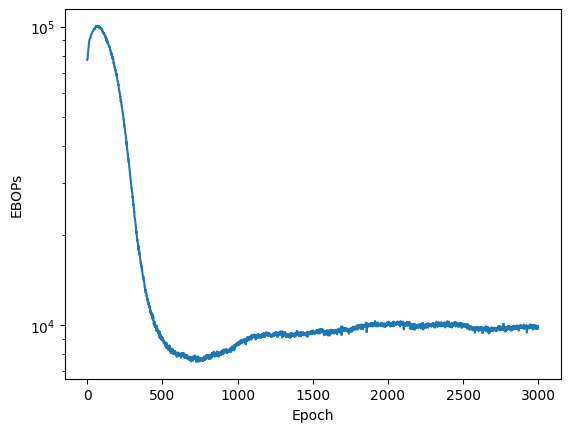

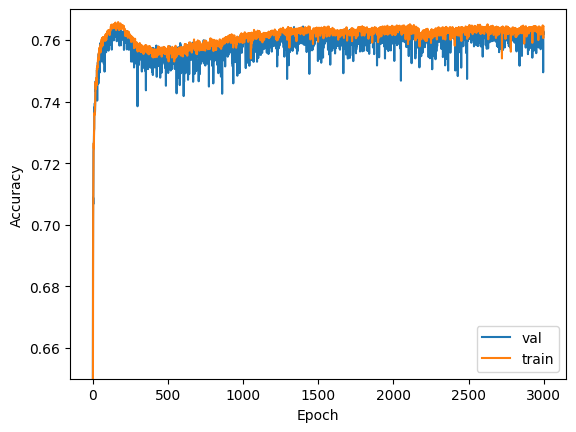

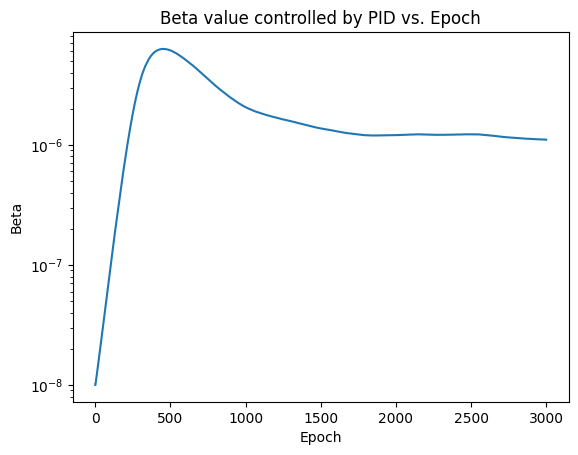

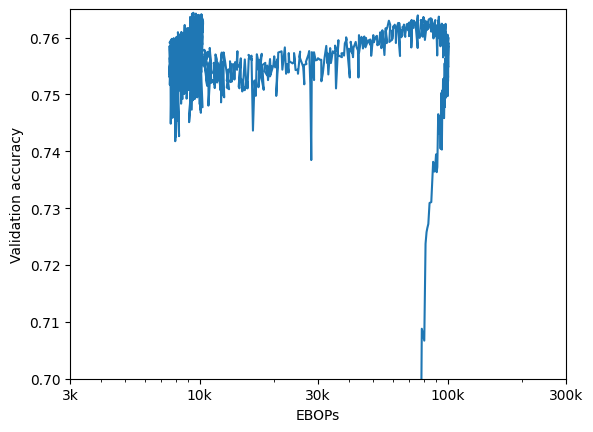

In [10]:
# ##############################################################################
# Section 9: Results Evaluation and Visualization
# This section first evaluates the final model's performance on the test set.
# Then, it uses matplotlib to plot several charts to visualize the changes in
# EBOPs and model accuracy during training.
# ##############################################################################

model.evaluate(dataset_test)

plt.plot(history.history['ebops'], '-')
plt.ylabel('EBOPs')
plt.yscale('log')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['val_accuracy'], '-', label='val')
plt.plot(history.history['accuracy'], '-', label='train')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim(0.65, 0.77)
plt.xlabel('Epoch')
plt.show()

if 'beta' in history.history:
    plt.plot(history.history['beta'], '-')
    plt.ylabel('Beta')
    plt.xlabel('Epoch')
    plt.title('Beta value controlled by PID vs. Epoch')
    plt.yscale('log') # The range of Beta values is large, so a logarithmic scale is used for the y-axis
    plt.show()

plt.plot(history.history['ebops'], history.history['val_accuracy'], '-')
plt.xscale('log')
plt.xlabel('EBOPs')
plt.ylabel('Validation accuracy')
plt.ylim(0.7, 0.765)
plt.xticks([3000, 10000, 30000, 100000, 300000], ['3k', '10k', '30k', '100k', '300k'])
plt.show()

In [11]:
# ##############################################################################
# Section 10: HLS Conversion Preparation (Revised with HLSConfig)
# ##############################################################################

import hls4ml
from hgq.utils import trace_minmax

print("Tracing activation ranges...")
trace_minmax(model, dataset_train)
print("Tracing finished.")

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

print("Extracting quantization parameters from HGQ model to build HLSConfig:")

# The logic of manual assignment is correct, but the data type from .bits is wrong.
# `quantizer.bits` returns a NumPy array, not a scalar integer. We must convert it.
for i, layer in enumerate(model.layers):
    if 'QDense' in str(type(layer)):
        quantizer = None
        
        if i < len(model.layers) - 1:
            next_layer = model.layers[i + 1]
            if hasattr(next_layer, 'iq'):
                quantizer = next_layer.iq
        else:
            if hasattr(layer, 'oq') and layer.enable_oq:
                quantizer = layer.oq
        
        if quantizer:
            # `quantizer.bits` returns an array, e.g., [[8. 8. ...]].
            # We need a single scalar integer for the hls4ml config string.
            # Since all bits in a layer are the same, we can take the first element.
            total_bits_array = quantizer.bits
            total_bits = int(total_bits_array[0][0]) # Extract scalar value

            integer_bits = None

            layer_name = layer.name
            if layer_name in ['dense_0', 'dense_1', 'dense_2']:
                integer_bits = 0
                print(f"  - Layer '{layer_name}': Manually assigning integer_bits=0 (from scope0 inheritance).")
            elif layer_name == 'dense_3':
                integer_bits = 3
                print(f"  - Layer '{layer_name}': Manually assigning integer_bits=3 (from oq_conf/scope1 inheritance).")

            if integer_bits is not None:
                precision_str = f'ap_fixed<{total_bits},{integer_bits}>'
                config['LayerName'][layer.name]['ResultPrecision'] = precision_str
                print(f"    -> Set precision to {precision_str}")
            else:
                 print(f"  - WARNING: Could not determine integer bits for layer '{layer.name}'. Skipping.")
        else:
            print(f"  - WARNING: Layer '{layer.name}' is a QDense layer, but a valid quantizer could not be determined. Skipping.")

# Set the precision for the final model output
last_layer = model.layers[-1]
if 'QDense' in str(type(last_layer)) and last_layer.enable_oq:
    total_bits_array = last_layer.oq.bits
    total_bits = int(total_bits_array[0][0])
    integer_bits = 3
    config['Model']['Precision'] = f'ap_fixed<{total_bits},{integer_bits}>'
    print(f"  - Model Output Precision set to: {config['Model']['Precision']}")

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'
Tracing activation ranges...
Tracing finished.
v2 handler used for layer dense_0
v2 handler used for layer dense_1
v2 handler used for layer dense_2
v2 handler used for layer dense_3
Extracting quantization parameters from HGQ model to build HLSConfig:
  - Layer 'dense_0': Manually assigning integer_bits=0 (from scope0 inheritance).
    -> Set precision to ap_fixed<0,0>
  - Layer 'dense_1': Manually assigning integer_bits=0 (from scope0 inheritance).
    -> Set precision to ap_fixed<8,0>
  - Layer 'dense_2': Manually assigning integer_bits=0 (from scope0 inheritance).
    -> Set precision to ap_fixed<7,0>
  - Layer 'dense_3': Manually assigning integer_bits=3 (from oq_conf/scope1 inheritance).
    -> Set precision to ap_fixed<5,3>
  - Model Output Precision set to: ap_fixed<5,3>


In [12]:
# ##############################################################################
# Section 11: HLS Conversion and Bit-Precision Validation (with HLSConfig)
#
# Now, we pass the manually created `config` to the conversion function.
# This ensures the HLS model is synthesized with bit-for-bit precision
# matching the HGQ software model, which should resolve the high mismatch rate.
# ##############################################################################

# Convert the Keras model using the explicit configuration
print("\nConverting to HLS model with explicit precision configuration...")
model_hls = hls4ml.converters.convert_from_keras_model(
    model,
    output_dir='/tmp/tt',
    hls_config=config  # <--- PASS THE CONFIG HERE
)
model_hls.compile()
print("HLS model compiled.")

print("Running predictions on Keras and HLS models...")
# Predict on the training set
p_keras_train = model.predict(dataset_train, verbose=0)
p_hls_train = model_hls.predict(np.ascontiguousarray(X_train))

# Predict on the test set
p_keras_test = model.predict(dataset_test, verbose=0)
p_hls_test = model_hls.predict(np.ascontiguousarray(X_test))
print("Predictions finished.")

print("Comparing classification decisions (argmax)...")
# Get final class predictions
keras_pred_train_class = np.argmax(p_keras_train, axis=1)
hls_pred_train_class = np.argmax(p_hls_train, axis=1)
keras_pred_test_class = np.argmax(p_keras_test, axis=1)
hls_pred_test_class = np.argmax(p_hls_test, axis=1)

# Compare predictions
n_mismatch_train = np.sum(keras_pred_train_class != hls_pred_train_class)
n_mismatch_test = np.sum(keras_pred_test_class != hls_pred_test_class)
n_train = len(keras_pred_train_class)
n_test = len(keras_pred_test_class)

accuracy_hls_vs_keras_train = (n_train - n_mismatch_train) / n_train
accuracy_hls_vs_keras_test = (n_test - n_mismatch_test) / n_test

print("\n--- HLS vs. Keras Equivalence Report ---")
print(f'Train Set Decision Mismatch: {n_mismatch_train}/{n_train} ({n_mismatch_train/n_train:.4%})')
print(f'Train Set Equivalence Accuracy (HLS vs Keras): {accuracy_hls_vs_keras_train:.4%}\n')
print(f'Test Set Decision Mismatch: {n_mismatch_test}/{n_test} ({n_mismatch_test/n_test:.4%})')
print(f'Test Set Equivalence Accuracy (HLS vs Keras): {accuracy_hls_vs_keras_test:.4%}')

from sklearn.metrics import accuracy_score

# Calculate the predictive accuracy of the HLS model on the test set
accuracy_hls_on_test = accuracy_score(y_test, hls_pred_test_class)

# Also calculate Keras model accuracy for reference
keras_pred_test_class_from_predict = np.argmax(p_keras_test, axis=1)
accuracy_keras_on_test = accuracy_score(y_test, keras_pred_test_class_from_predict)

print("\n--- Predictive Performance Report ---")
print(f'Keras Model Accuracy on Test Set: {accuracy_keras_on_test:.4%}')
print(f'HLS Model Accuracy on Test Set:   {accuracy_hls_on_test:.4%}')


Converting to HLS model with explicit precision configuration...
v2 handler used for layer dense_0
v2 handler used for layer dense_1
v2 handler used for layer dense_2
v2 handler used for layer dense_3
Writing HLS project
Done
HLS model compiled.
Running predictions on Keras and HLS models...
Predictions finished.
Comparing classification decisions (argmax)...

--- HLS vs. Keras Equivalence Report ---
Train Set Decision Mismatch: 527652/664000 (79.4657%)
Train Set Equivalence Accuracy (HLS vs Keras): 20.5343%

Test Set Decision Mismatch: 131748/166000 (79.3663%)
Test Set Equivalence Accuracy (HLS vs Keras): 20.6337%

--- Predictive Performance Report ---
Keras Model Accuracy on Test Set: 76.1994%
HLS Model Accuracy on Test Set:   19.9988%


--- Starting Run 1/9: Target EBOPs = 625.0 ---


Run 1/9 | Target: 625 | loss: 0.916 - acc: 0.715 - ebops: 586 - beta: 1.06e-04 - EBOPs: 586: 100%|█| 1000/1000 [01:14<00


--- Finished Run 1. Target: 625, Final Val Acc: 0.7267, Final EBOPs: 586 ---

--- Starting Run 2/9: Target EBOPs = 1250.0 ---


Run 2/9 | Target: 1,250 | loss: 0.785 - acc: 0.740 - ebops: 1,149 - beta: 2.71e-05 - EBOPs: 1,149: 100%|█| 1000/1000 [01


--- Finished Run 2. Target: 1,250, Final Val Acc: 0.7319, Final EBOPs: 1,149 ---

--- Starting Run 3/9: Target EBOPs = 2500.0 ---


Run 3/9 | Target: 2,500 | loss: 0.742 - acc: 0.748 - ebops: 2,313 - beta: 1.16e-05 - EBOPs: 2,313: 100%|█| 1000/1000 [01


--- Finished Run 3. Target: 2,500, Final Val Acc: 0.7465, Final EBOPs: 2,313 ---

--- Starting Run 4/9: Target EBOPs = 5000.0 ---


Run 4/9 | Target: 5,000 | loss: 0.707 - acc: 0.756 - ebops: 4,601 - beta: 4.54e-06 - EBOPs: 4,601: 100%|█| 1000/1000 [01


--- Finished Run 4. Target: 5,000, Final Val Acc: 0.7546, Final EBOPs: 4,601 ---

--- Starting Run 5/9: Target EBOPs = 10000.0 ---


Run 5/9 | Target: 10,000 | loss: 0.685 - acc: 0.762 - ebops: 8,731 - beta: 1.77e-06 - EBOPs: 8,731: 100%|█| 1000/1000 [0


--- Finished Run 5. Target: 10,000, Final Val Acc: 0.7603, Final EBOPs: 8,731 ---

--- Starting Run 6/9: Target EBOPs = 20000.0 ---


Run 6/9 | Target: 20,000 | loss: 0.672 - acc: 0.764 - ebops: 17,276 - beta: 7.01e-07 - EBOPs: 17,276: 100%|█| 1000/1000 


--- Finished Run 6. Target: 20,000, Final Val Acc: 0.7620, Final EBOPs: 17,276 ---

--- Starting Run 7/9: Target EBOPs = 40000.0 ---


Run 7/9 | Target: 40,000 | loss: 0.659 - acc: 0.768 - ebops: 33,895 - beta: 3.04e-07 - EBOPs: 33,895: 100%|█| 1000/1000 


--- Finished Run 7. Target: 40,000, Final Val Acc: 0.7653, Final EBOPs: 33,895 ---

--- Starting Run 8/9: Target EBOPs = 80000.0 ---


Run 8/9 | Target: 80,000 | loss: 0.652 - acc: 0.769 - ebops: 71,945 - beta: 9.99e-08 - EBOPs: 71,945: 100%|█| 1000/1000 


--- Finished Run 8. Target: 80,000, Final Val Acc: 0.7661, Final EBOPs: 71,945 ---

--- Starting Run 9/9: Target EBOPs = 160000.0 ---


Run 9/9 | Target: 160,000 | loss: 0.642 - acc: 0.770 - ebops: 147,772 - beta: 7.70e-09 - EBOPs: 147,772: 100%|█| 1000/10


--- Finished Run 9. Target: 160,000, Final Val Acc: 0.7670, Final EBOPs: 147,772 ---



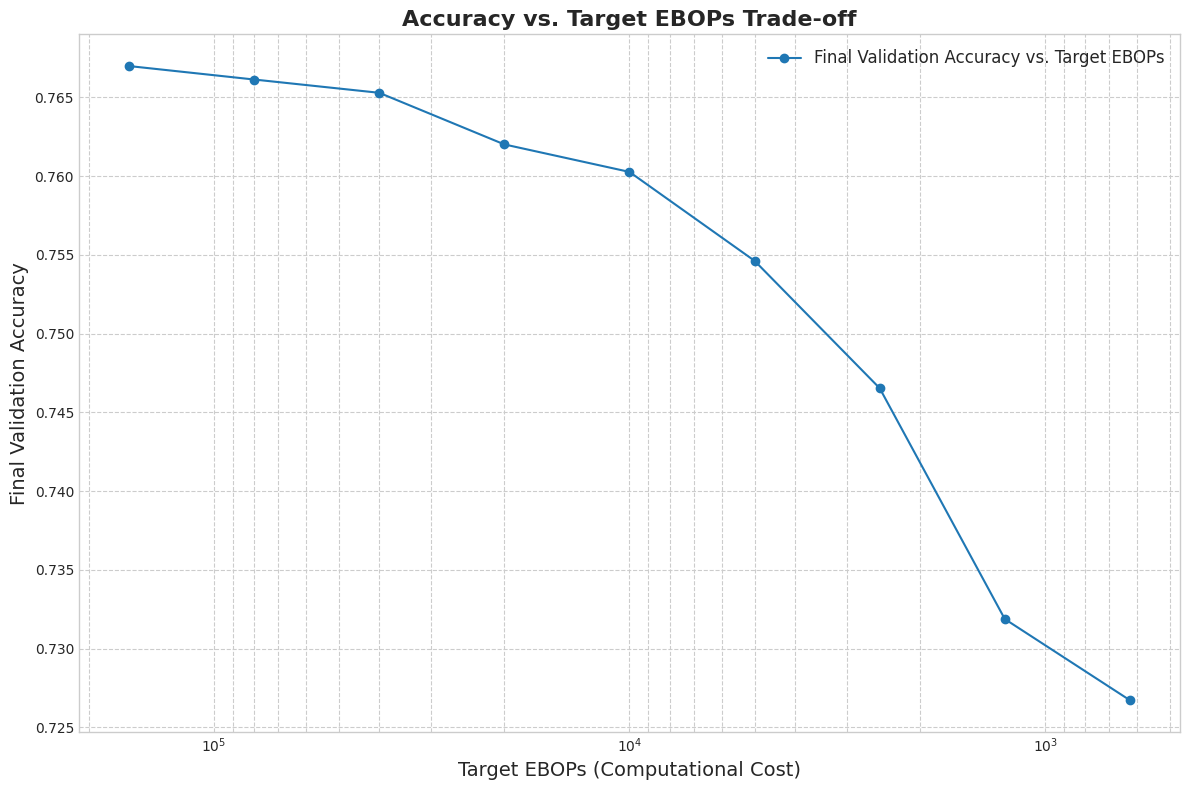

In [13]:
# ##############################################################################
# Section 12: Accuracy vs. Target EBOPs Trade-off Analysis (Revised)
# This section systematically trains multiple models, each with a different
# target_ebops constraint. It uses a single, effective PID configuration to
# drive the model towards its respective target. The final plot shows the
# trade-off between the target computational cost (EBOPs) and the achieved
# validation accuracy.
# ##############################################################################

# Define a range of target EBOPs to evaluate
target_ebops_sweep = [6.25e2,1.25e3,2.5e3,5e3,1e4,2e4,4e4,8e4,1.6e5]
results = []
TRAINING_EPOCHS = 1000

# Use a single, more powerful PID configuration for all runs
pid_config = {'p': 1e-2, 
              'i': 1e-2, 
              'd': 1e-2}

for i, target in enumerate(target_ebops_sweep):
    print(f"--- Starting Run {i+1}/{len(target_ebops_sweep)}: Target EBOPs = {target} ---")

    keras.utils.clear_session()
    np.random.seed(42)
    random.seed(42)
    model = build_model(use_softmax=use_softmax)

    if not use_softmax:
        loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    else:
        loss = keras.losses.CategoricalHinge()
    opt = keras.optimizers.Adam(learning_rate=5e-3)
    model.compile(opt, loss, metrics=['accuracy'], jit_compile=True, steps_per_execution=4)

    pbar = PBar(f"Run {i+1}/{len(target_ebops_sweep)} | Target: {target:,.0f} | " + 'loss: {loss:.3f} - acc: {accuracy:.3f} - ebops: {ebops:,.0f} - beta: {beta:.2e}')
    ebops_callback = FreeEBOPs()
    nan_terminate = keras.callbacks.TerminateOnNaN()

    beta_pid_controller = BetaPID(
        p=pid_config['p'],
        i=pid_config['i'],
        d=pid_config['d'],
        target_ebops=target,
        warmup=1,
        init_beta=1e-7,
        max_beta=1e-2,
        damp_beta_on_target=0
    )

    callbacks = [ebops_callback, beta_pid_controller, nan_terminate, pbar]

    history = model.fit(
        dataset_train,
        epochs=TRAINING_EPOCHS,
        batch_size=33200,
        validation_data=dataset_test,
        verbose=0,
        callbacks=callbacks
    )

    final_val_accuracy = history.history['val_accuracy'][-1]
    final_ebops = history.history['ebops'][-1]
    
    results.append({
        'target_ebops': target,
        'final_val_accuracy': final_val_accuracy,
        'final_ebops': final_ebops,
    })
    print(f"--- Finished Run {i+1}. Target: {target:,.0f}, Final Val Acc: {final_val_accuracy:.4f}, Final EBOPs: {final_ebops:,.0f} ---\n")

# --- Plotting the Final Trade-off Curve ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Extract data for plotting
targets = [r['target_ebops'] for r in results]
accuracies = [r['final_val_accuracy'] for r in results]
achieved_ebops = [r['final_ebops'] for r in results]

# Plotting achieved accuracy vs. target ebops
ax.plot(targets, accuracies, 'o-', label='Final Validation Accuracy vs. Target EBOPs')

ax.set_xlabel('Target EBOPs (Computational Cost)', fontsize=14)
ax.set_ylabel('Final Validation Accuracy', fontsize=14)
ax.set_title('Accuracy vs. Target EBOPs Trade-off', fontsize=16, fontweight='bold')
ax.grid(True, which="both", ls="--")
ax.legend(fontsize=12)
ax.set_xscale('log') # EBOPs often span orders of magnitude, log scale is good
plt.gca().invert_xaxis() # Lower EBOPs (better) are on the right
plt.tight_layout()
plt.show()